# Tanzanian Water Well Dysfunction

## Overview

The machine learning model developed for this project will be trained to classify water pumps into one of three categories: functional, in need of repairs, or non-functional. The predictions made by the model will include identifying non-functional pumps, thus aiding in prioritizing maintenance efforts to address issues promptly and ensure a sustainable and reliable water supply for communities.

## Business Understanding

In Tanzania, ensuring the accessibility and functionality of water pumps is vital for delivering clean and potable water to communities. Many rural areas rely on these pumps for their water supply. However, issues such as pump malfunctions and breakdowns can lead to water scarcity, impacting public health, agriculture, and overall community well-being.

The primary goal of this project is to develop a predictive maintenance model for water pumps, enabling proactive identification of pumps at risk of dysfunctionality. By leveraging machine learning, we aim to optimize maintenance operations, prioritize interventions, and minimize downtime for non-functional pumps.

### Baseline Model

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder,StandardScaler , LabelEncoder
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report ,plot_confusion_matrix , confusion_matrix
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

from imblearn.pipeline import Pipeline

# set seaborn display
sns.set_theme(context='talk', style='white')

#### load clean data set

    load test and clean feature data set

In [5]:
features =pd.read_csv('../Data/clean_data.csv' , index_col=0)

In [6]:
features.status_group.value_counts(normalize=True)

functional                 0.547146
non functional             0.386622
functional needs repair    0.066232
Name: status_group, dtype: float64

### Target
our target column is status_group
- 0 Funcional
- 1 Functional , needs repair
- 2 non functional

Class imbalance is observed, where 'functional' and 'non-functional' are balanced, but the 'functional needs repair' category constitutes only 6.5%

In [7]:
#casting the data type of region and district code to object , they needed to be catagorical
features['region_code'] = features['region_code'].astype('O')
features['district_code'] = features['district_code'].astype('O')

In [8]:
#numerical and catagorical columns
cat_columns=list(features.select_dtypes(include='O').columns)
num_columns=list(features.select_dtypes(exclude='O').columns)

In [9]:
cat_columns.remove('status_group')

In [10]:
len(cat_columns)

14

In [11]:
len(num_columns)

9

In [12]:
# create features and target
X = features.drop('status_group', axis=1)
y = features.status_group

encoder = LabelEncoder()
y_dummies = encoder.fit_transform(y)


# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_dummies, test_size=0.2, random_state=42)

In [13]:
y_dummies

array([0, 0, 2, ..., 0, 0, 0])

### Column Transform

In [14]:
num_pipeline = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='median' ,add_indicator=True)),
    ('ss', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('impute_cat', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore',sparse=True))
])

In [15]:
col_trans=ColumnTransformer(transformers=[
    ('nums', num_pipeline, num_columns),
    ('cats', cat_pipeline, cat_columns)
], remainder='passthrough', n_jobs=-1)

In [16]:
np.bincount(y_train)

array([21912,  2635, 15566], dtype=int64)

In [17]:
dummy_pipeline = Pipeline([
    ('col_trans', col_trans),
    ('dummyC', DummyClassifier())
])

dummy_pipeline.fit(X_train, y_train)

C:\Users\Windows-10\anaconda3\envs\learn-env\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
           

In [18]:
dummy_pipeline.score(X_train , y_train) , dummy_pipeline.score(X_test , y_test)

(0.4544162740258769, 0.4548808455479111)

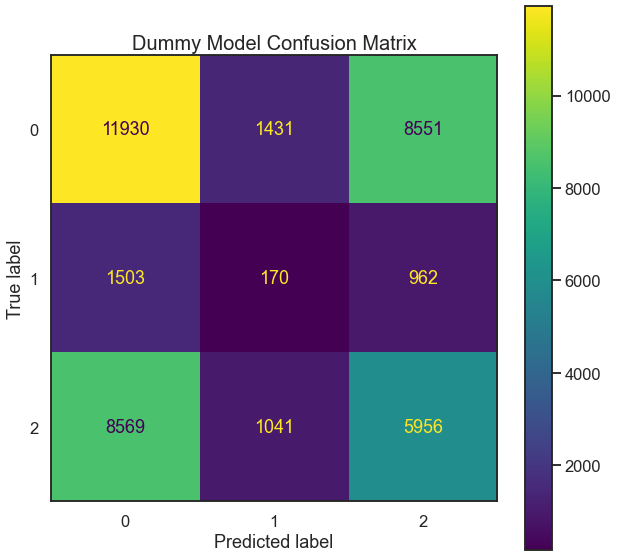

In [19]:
y_pred_train = dummy_pipeline.predict(X_train)
cm = confusion_matrix(y_train, y_pred_train)

# Display the confusion matrix using ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Dummy Model Confusion Matrix', fontsize=20)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy_pipeline.classes_).plot(ax=ax)
plt.show()

### Logistic regression

In [20]:
# first simple model
logreg_pipe = Pipeline([
    ('colt', col_trans),
    ('logreg', LogisticRegression(C=0.1 ,n_jobs=-1))
])

logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('colt',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
                

In [21]:
logreg_pipe.score(X_train , y_train)

0.7693266522075137

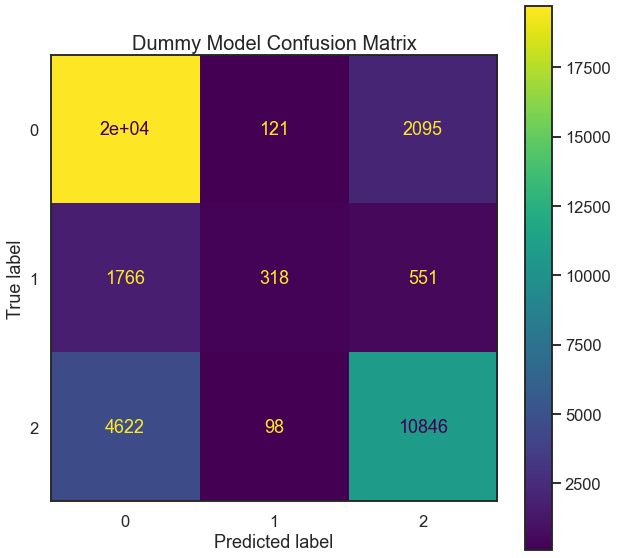

In [22]:
y_pred_train = logreg_pipe.predict(X_train)
cm = confusion_matrix(y_train, y_pred_train)

# Display the confusion matrix using ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Dummy Model Confusion Matrix', fontsize=20)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy_pipeline.classes_).plot(ax=ax)
plt.show()

#### Handling imbalance with class_weight balance

In [31]:
logistic_reg = Pipeline([
    ('colt', col_trans),
    ('logreg', LogisticRegression(class_weight='balanced',C=0.1,n_jobs=-1))
])

logistic_reg.fit(X_train, y_train)

Pipeline(steps=[('colt',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
                

In [32]:
logistic_reg.score(X_train, y_train)

0.6744197641662304

In [33]:
y_test_pred4 = logistic_reg.predict(X_test)
print(classification_report(y_test, y_test_pred4))

              precision    recall  f1-score   support

           0       0.83      0.66      0.74      5523
           1       0.22      0.74      0.34       686
           2       0.78      0.67      0.72      3820

    accuracy                           0.67     10029
   macro avg       0.61      0.69      0.60     10029
weighted avg       0.77      0.67      0.70     10029



the presented recall scores shed light on the model's effectiveness in identifying water pump functionality categories. The higher recall for Class 1 (Functional Needs Repair) underscores its strong performance in identifying pumps requiring attention. However, the slightly lower recall for Class 0 (Functional) suggests room for improvement. Achieving a balanced and high recall across all classes is crucial for comprehensive water pump management. While the overall accuracy stands at 67%, there exists untapped potential for enhancement. The introduction of more complex models holds promise, as advanced algorithms may capture intricate patterns, leading to improved recall scores and overall predictive accuracy. In moving forward, further exploration and experimentation with sophisticated algorithms are recommended to refine the model's performance and better address the intricacies associated with water pump functionality prediction.